In [6]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import my_utils
from sklearn.preprocessing import MinMaxScaler
import torch
from torch.utils.data import TensorDataset, DataLoader, random_split

In [3]:
df = pd.DataFrame([1,2,3,4,132,6,700,8,9,10,11])
my_utils.hampel_filtering(df,window_size=5)

,0
0,1.00
1,2.00
2,3.00
3,4.00
4,3.90
5,6.00
6,5.79
7,8.00
8,9.00
9,10.00


In [3]:
def extract_amp_phase(path, names = ('amp_no_name.csv', 'phase_no_name.csv')): 
    '''Returns and save 2 different datasets, 
    1 for the amplitude 1 for the phase, both with 64 features.
    It combines the I/Q samples to produce the results.
    '''
    data_0 = pd.read_csv(path)
    data_0 = data_0['CSI_DATA'].str.strip('[]').apply(lambda x: [int(num) for num in x.split()])

    def compute_amplitude(arr):
        arr = np.array(arr)
        return np.sqrt(np.sum(arr.reshape(-1, 2)**2, axis=1))

    def compute_atan2(arr):
        arr = np.array(arr)
        imaginary, real = arr[::2], arr[1::2] # imaginary = y = Q and real = x = I of I/Q-Sampling
        return np.arctan2(imaginary, real) # argument order is (y,x) NOT (x,y), returns Radians

    amp_data = data_0.apply(compute_amplitude)
    phase_data = data_0.apply(compute_atan2)
    amp_data = pd.DataFrame(amp_data.tolist(), columns=[f'subc{i-32}' for i in range(64)]).iloc[:,6:59].drop('subc0',axis=1)  # remove guard subcarriers
    phase_data = pd.DataFrame(phase_data.tolist(), columns=[f'subc{i-32}' for i in range(64)]).iloc[:,6:59].drop('subc0', axis=1)  # remove guard subcarriers
    amp_data.to_csv('..\Data\DataClean\\' + names[0], index=False)
    phase_data.to_csv('..\Data\DataClean\\' + names[1], index=False)
    return amp_data, phase_data

In [3]:
if False:
    data_amp, data_pha = extract_amp_phase('..\Data\empty6.csv', names=('empty6_amp.csv', 'empty6_phase.csv'))
else:
    data_amp, data_pha = pd.read_csv('..\Data\DataClean\empty6_amp.csv'), pd.read_csv('..\Data\DataClean\empty6_phase.csv')
    fra_amp, fra_pha = pd.read_csv('..\Data\DataClean\\fra1_amp.csv'), pd.read_csv('..\Data\DataClean\\fra1_phase.csv')
    la_amp, la_pha = pd.read_csv('..\Data\DataClean\laura1_amp.csv'), pd.read_csv('..\Data\DataClean\laura1_phase.csv')
    
fra_amp.describe()

,subc-26,subc-25,subc-24,subc-23,subc-22,subc-21,subc-20,subc-19,subc-18,subc-17,...,subc17,subc18,subc19,subc20,subc21,subc22,subc23,subc24,subc25,subc26
count,11900.000000,11900.000000,11900.000000,11900.000000,11900.000000,11900.000000,11900.000000,11900.000000,11900.000000,11900.000000,...,11900.000000,11900.000000,11900.000000,11900.000000,11900.000000,11900.000000,11900.000000,11900.000000,11900.000000,11900.000000
mean,13.066683,12.973430,13.889749,14.540368,14.743252,13.852717,14.383304,14.546495,15.114552,15.098280,...,15.572605,13.708393,14.394056,13.936097,15.127344,15.035818,15.866839,15.505553,16.061698,15.292935
std,1.263775,1.256811,1.378467,1.383441,1.416488,1.370475,1.374548,1.382116,1.443876,1.491218,...,1.819054,1.578318,1.619873,1.564209,1.642478,1.669890,1.684250,1.691969,1.684831,1.570810
min,6.324555,7.280110,8.944272,8.000000,7.615773,8.246211,7.810250,8.602325,9.055385,9.055385,...,9.433981,8.062258,8.544004,7.615773,8.944272,8.544004,9.848858,9.219544,9.848858,9.000000
25%,12.165525,12.083046,13.038405,13.601471,13.892444,13.000000,13.453624,13.601471,14.142136,14.142136,...,14.422205,12.806248,13.416408,13.000000,14.142136,14.035669,14.866069,14.317821,15.000000,14.212670
50%,13.038405,13.000000,13.928388,14.422205,14.764823,13.892444,14.317821,14.422205,15.033296,15.033296,...,15.524175,13.601471,14.317821,13.928388,15.033296,15.000000,15.811388,15.297059,16.031220,15.231546
75%,13.892444,13.601471,14.764823,15.297059,15.620499,14.764823,15.231546,15.297059,16.031220,16.124515,...,16.492423,14.560220,15.264338,14.866069,16.124515,16.031220,17.000000,16.401219,17.029386,16.155494
max,44.181444,39.115214,58.249464,43.174066,46.872167,57.558666,52.611786,41.436699,48.259714,51.009803,...,124.310096,93.941471,96.690227,84.646323,95.036835,96.317184,89.888820,102.961158,94.366308,74.215901


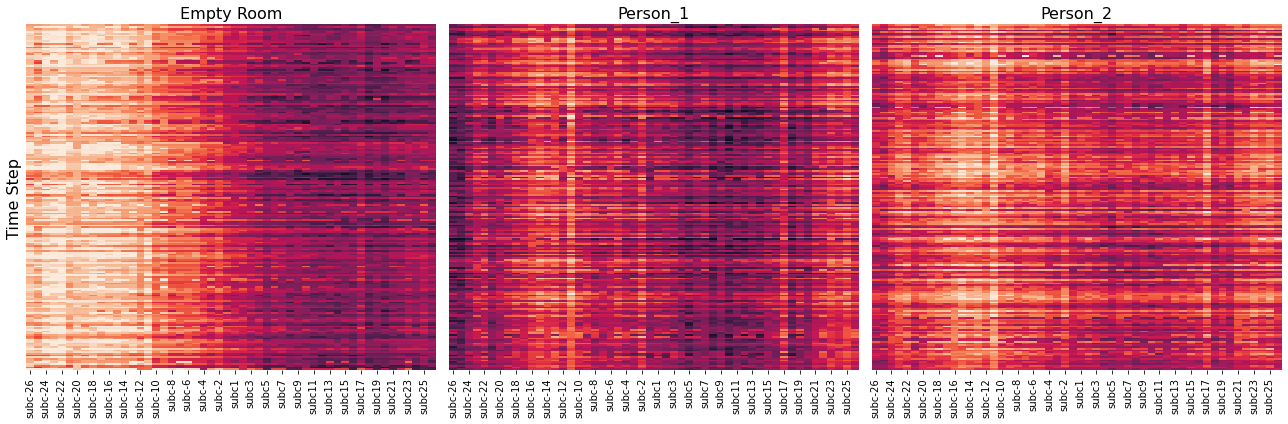

In [74]:
#data_amp_c = my_utils.hampel_filtering(data_amp, window_size=51, thresh=3).loc[800:901, :]
#fra_amp_c = my_utils.hampel_filtering(fra_amp, window_size=51, thresh=3).loc[800:901, :]
#la_amp_c = my_utils.hampel_filtering(la_amp, window_size=51, thresh=3).loc[800:901, :]
data_amp_c = pd.read_csv(f'..\Data\DataPreprocessed\empty1_w51_hamp_sf08.csv').loc[800:1001, :]
fra_amp_c = pd.read_csv(f'..\Data\DataPreprocessed\\fra1_w51_hamp_sf08.csv').loc[800:1001, :]
la_amp_c = pd.read_csv(f'..\Data\DataPreprocessed\laura1_w51_hamp_sf08.csv').loc[800:1001, :]
gio_amp_c = pd.read_csv(f'..\Data\DataPreprocessed\gio1_w51_hamp_sf08.csv').loc[800:1001, :]
vmin = min(data_amp_c.values.min(), fra_amp_c.values.min(), gio_amp_c.values.min())
vmax = min(data_amp_c.values.max(), fra_amp_c.values.max(), gio_amp_c.values.max())
fig, axes = plt.subplots(1, 3, figsize=(18,6))
# Plot the first heatmap
sns.heatmap(data_amp_c, ax=axes[0], vmin=vmin, vmax=vmax, cbar=False)
axes[0].set_title("Empty Room", fontsize=16)
axes[0].set_yticks([])
axes[0].set_ylabel("Time Step", fontsize=16)
# Plot the second heatmap
sns.heatmap(fra_amp_c, ax=axes[1], vmin=vmin, vmax=vmax, cbar=False)
axes[1].set_title("Person_1", fontsize=16)
axes[1].set_yticks([])
sns.heatmap(gio_amp_c, ax=axes[2], vmin=vmin, vmax=vmax, cbar=False)
axes[2].set_title("Person_2", fontsize=16)
axes[2].set_yticks([])
plt.subplots_adjust(wspace=0.2)
plt.tight_layout()
plt.show()

In [99]:
data_p = pd.read_csv(f'..\Data\DataPreprocessed\empty1_calibratedPha.csv').loc[800:1001, :]
fra_p = pd.read_csv(f'..\Data\DataPreprocessed\\fra1_calibratedPha.csv').loc[800:1001, :]


<Figure size 432x288 with 0 Axes>

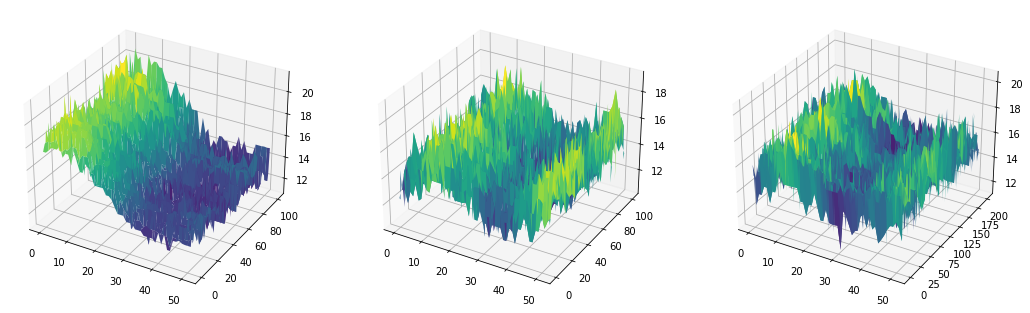

In [113]:
data_amp_c = pd.read_csv(f'..\Data\DataPreprocessed\empty1_w51_hamp_sf08.csv').loc[800:901, :]
fra_amp_c = pd.read_csv(f'..\Data\DataPreprocessed\\fra1_w51_hamp_sf08.csv').loc[800:901, :]
la_amp_c = pd.read_csv(f'..\Data\DataPreprocessed\laura1_w51_hamp_sf08.csv').loc[800:1001, :]
gio_amp_c = pd.read_csv(f'..\Data\DataPreprocessed\gio1_w51_hamp_sf08.csv').loc[800:1001, :]

# Create X and Y coordinates for the grid
X, Y = np.meshgrid(np.arange(data_amp_c.shape[1]), np.arange(data_amp_c.shape[0]))
# Z values from the DataFrame
Z = data_amp_c.values
X1, Y1 = np.meshgrid(np.arange(fra_amp_c.shape[1]), np.arange(fra_amp_c.shape[0]))
# Z values from the DataFrame
Z1 = fra_amp_c.values
X2, Y2 = np.meshgrid(np.arange(gio_amp_c.shape[1]), np.arange(gio_amp_c.shape[0]))
Z2 = gio_amp_c.values
# Create a 3D plot
fig = plt.figure()
fig, axes = plt.subplots(1, 3, figsize=(18,6), subplot_kw={'projection': '3d'})
# Plot the 3D surface with colormap
surface = axes[0].plot_surface(X, Y, Z, cmap='viridis')
axes[1].plot_surface(X1, Y1, Z1, cmap='viridis')
axes[2].plot_surface(X2, Y2, Z2, cmap='viridis')
# Customize the plot
'''
ax.set_xlabel('X Axis')
ax.set_ylabel('Y Axis')
ax.set_zlabel('Z Axis')
ax.set_title('3D Heatmap')
'''
# Add color bar to indicate values
fig.colorbar(surface, ax=ax, label='Z Values')

# Show the plot
plt.show()

In [118]:
data_pha_c = pd.read_csv(f'..\Data\DataPreprocessed\laura1_calibratedPha.csv')
gio_pha_c = pd.read_csv(f'..\Data\DataPreprocessed\gio1_calibratedPha.csv')
fra_pha_c = pd.read_csv(f'..\Data\DataPreprocessed\\fra1_calibratedPha.csv')

3.2434693384347133

In [11]:
a = pd.DataFrame(np.array([1,2,3,4,5,6,10101,6,3431,1,]).reshape(-1,1))
my_utils.hampel_filtering(a, window_size=7, smoothing_factor=0.5)

,0
0,1.00
1,2.00
2,3.00
3,4.00
4,5.00
5,6.00
6,5.25
7,6.00
8,6.00
9,1.00


(11843, 52)


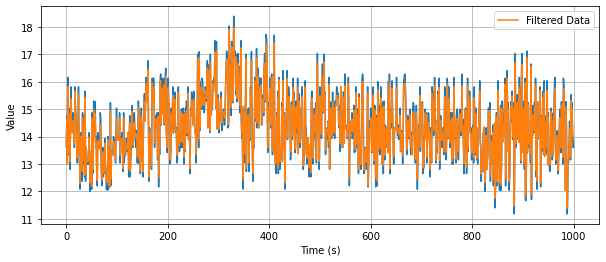

(11844, 52)


In [7]:
import numpy as np
import matplotlib.pyplot as plt
import pywt
import pywt.data
data_amp = pd.read_csv(f'..\Data\DataPreprocessed\\fra3_w51_hamp_sf08.csv')
print(data_amp.shape)
wavelet = 'haar'
level = 5
threshold = 0.2
# Perform the DWT
coeffs = pywt.wavedec(data_amp, wavelet, level=level, axis=0)

def soft_threshold(value, threshold):
    return np.where(value > threshold, value - threshold, np.where(value < -threshold, value + threshold, 0.0))

# Threshold the coefficients for each level and each column
denoised_coeffs = [soft_threshold(coeff, threshold) for coeff in coeffs]

denoised_signal = pywt.waverec(denoised_coeffs, wavelet, axis=0)

plt.figure(figsize=(10, 4))
plt.plot(data_amp.loc[:1000, 'subc9'])
plt.plot(denoised_signal[:1000,34], label='Filtered Data',)
plt.legend()
plt.xlabel('Time (s)')
plt.ylabel('Value')
plt.grid(True)
plt.show()
print(denoised_signal.shape)

In [5]:
def make_alternating(amp,pha):
    ''' this code combine amplitude and phase in an alternating way like: 
    [a1,p1, a2,p2, ..., a64,p64] where aN and pN are
    amplitude and phase of subcarrier N
    '''
    ampNP = amp.to_numpy()[:, :, np.newaxis]
    phaNP = pha.to_numpy()[:, :, np.newaxis]
    data = np.concatenate((ampNP, phaNP), axis=2)
    data = data.reshape(data.shape[0],-1)
    return data

In [6]:
#dataset = make_alternating(data_amp, data_pha)
#make_alternating(pd.DataFrame( [[1,2,3], [10,20,30], [100,200,300]] ), pd.DataFrame( [[-1,-2,-3], [-10,-20,-30], [-100,-200,-300]]))

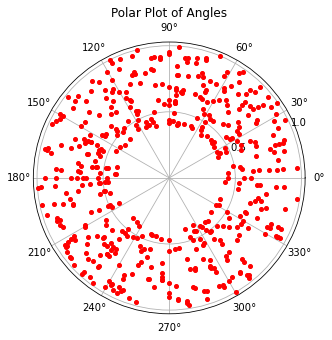

count    501.000000
mean       0.111446
std        1.847853
min       -3.075024
25%       -1.504228
50%        0.298499
75%        1.647568
max        3.141593
Name: subc9, dtype: float64

In [3]:
angles_radians = data_pha.loc[1000:1500,'subc9'] 
#print(angles_radians)
# Create a polar plot
plt.figure(figsize=(5, 5))  # Adjust the figure size as needed
distance = np.random.uniform(0.4, 1, len(angles_radians))
plt.polar(angles_radians, distance, 'ro', markersize=4)  # 'ro' for red circles, adjust marker style as needed

# Set polar plot attributes
plt.thetagrids(range(0, 360, 30))  # Customize angle labels
plt.rgrids([0.5, 1.0], labels=['0.5', '1.0'])  # Customize radial grid lines and labels
plt.title("Polar Plot of Angles")

# Show the polar plot
plt.show()
angles_radians.describe()

In [4]:
def convert_to_bounded_angle(angles):
    # Use modulo to wrap angles into the [0, 2π) range
    bounded_angles = angles % (2 * np.pi)
    # Ensure the result is positive
    bounded_angles[bounded_angles < 0] += 2 * np.pi
    return bounded_angles

def phase_sanitization(row):
    a = (row[-1] - row[0]) / 52
    b = row.mean()
    mi_values = np.concatenate((np.arange(-26, 0),np.arange(1,27)))
    row = row - (a * mi_values) - b
    return row

calibrated_phase = data_pha.apply(phase_sanitization, axis=1)
sanitized_phase = calibrated_phase.apply(convert_to_bounded_angle, axis=1)

In [13]:
half_1 = np.arange(7, 33)
half_2 = np.arange(34, 60)
mi_values = np.concatenate((half_1, half_2))
np.concatenate((np.arange(-26, 0),np.arange(1,27)))

array([-26, -25, -24, -23, -22, -21, -20, -19, -18, -17, -16, -15, -14,
       -13, -12, -11, -10,  -9,  -8,  -7,  -6,  -5,  -4,  -3,  -2,  -1,
         1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,  13,
        14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,  26])

In [9]:
# Example usage:
angles = np.array([-9*np.pi/2, -np.pi/2, np.pi, 3*np.pi/2, 5*np.pi/2])
bounded_angles = convert_to_bounded_angle(angles)
print(np.rad2deg(bounded_angles))
print(np.rad2deg(angles))

[270. 270. 180. 270.  90.]
[-810.  -90.  180.  270.  450.]


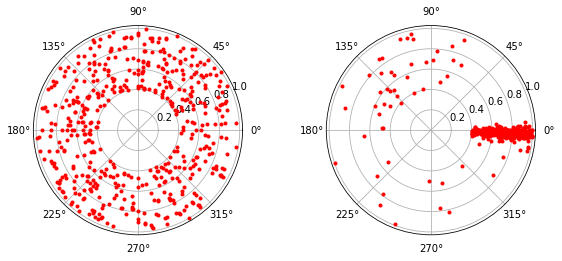

In [5]:
fig, axes = plt.subplots(1, 2, figsize=(9,5), subplot_kw={'projection': 'polar'})
subc26 = sanitized_phase.loc[1000:1500,'subc9']
axes[1].plot(subc26, distance, 'ro', markersize=3)
axes[0].plot(angles_radians, distance, 'ro', markersize=3)
plt.subplots_adjust(wspace=0.4)

In [11]:
mi_values_first = np.arange(7, 33)
mi_values_second = np.arange(34, 60)
a = np.concatenate((mi_values_first,mi_values_second)) - 33
a

array([-26, -25, -24, -23, -22, -21, -20, -19, -18, -17, -16, -15, -14,
       -13, -12, -11, -10,  -9,  -8,  -7,  -6,  -5,  -4,  -3,  -2,  -1,
         1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,  13,
        14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,  26])

In [12]:
#amp_no_out = replace_outliers(data_amp, std_threshold=2.5)

In [13]:
'''fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 6), sharey=True)
data = data_amp.loc[3234:4234,'subc42']
dataClean = amp_no_out.loc[3234:4234,'subc42']
treshUp = data.mean() + 2.5 * data.std()
treshDown = data.mean() - 2.5 * data.std()
ax1.plot(np.arange(0,1001),data)
ax2.plot(np.arange(0,1001),dataClean)
ax1.hlines((treshUp, treshDown),0,1001, color='red')
#ax2.plot(np.arange(0,401),data_amp.loc[3234:3634,'subc9'])'''

"fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 6), sharey=True)\ndata = data_amp.loc[3234:4234,'subc42']\ndataClean = amp_no_out.loc[3234:4234,'subc42']\ntreshUp = data.mean() + 2.5 * data.std()\ntreshDown = data.mean() - 2.5 * data.std()\nax1.plot(np.arange(0,1001),data)\nax2.plot(np.arange(0,1001),dataClean)\nax1.hlines((treshUp, treshDown),0,1001, color='red')\n#ax2.plot(np.arange(0,401),data_amp.loc[3234:3634,'subc9'])"

In [6]:
def weighted_mean(window):
    weights = [0.10, 0.15, 0.75]
    return np.dot(window, weights)

#amp_smooth = amp_no_out_MAD.rolling(window=3).apply(weighted_mean, raw=True)
amp_hamp = my_utils.hampel_filtering(data_amp, window_size=51, thresh=3)
#amp_hamp_smooth= amp_hamp.rolling(window=3).apply(weighted_mean, raw=True)

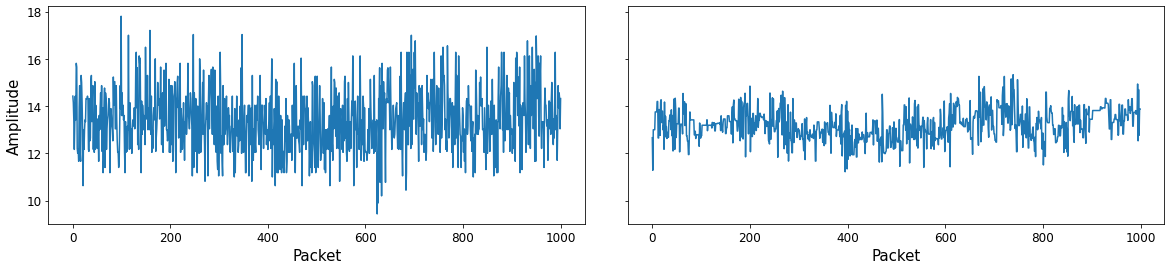

In [47]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 4), sharey=True )
data = pd.read_csv(f'..\Data\DataClean\\fra1_amp.csv')
data_amp = pd.read_csv(f'..\Data\DataPreprocessed\\fra1_w51_hamp_sf08.csv')
wavelet = 'haar'
level = 5
threshold = 0.7
# Perform the DWT
coeffs = pywt.wavedec(data_amp, wavelet, level=level, axis=0)

def soft_threshold(value, threshold):
    return np.where(value > threshold, value - threshold, np.where(value < -threshold, value + threshold, 0.0))

# Threshold the coefficients for each level and each column
denoised_coeffs = [soft_threshold(coeff, threshold) for coeff in coeffs]

denoised_signal = pywt.waverec(denoised_coeffs, wavelet, axis=0)

#dataClean = amp_no_out_MAD.loc[4034:5034,'subc9']
#dataSmooth = amp_hamp_smooth.loc[3534:4534,'subc12']
ax1.plot(data.loc[3034:4034, 'subc12'].to_numpy())
ax2.plot(denoised_signal[3034:4034, 37])
ax1.set_ylabel('Amplitude', fontsize=15)
ax1.set_xlabel('Packet', fontsize=15)
ax2.set_xlabel('Packet', fontsize=15)
ax1.tick_params(axis='both', which='both', labelsize=12)  # Adjust the fontsize as needed
ax2.tick_params(axis='both', which='both', labelsize=12) 
#ax3.plot(np.arange(0,501),dataSmooth)
plt.subplots_adjust(wspace=0.08)

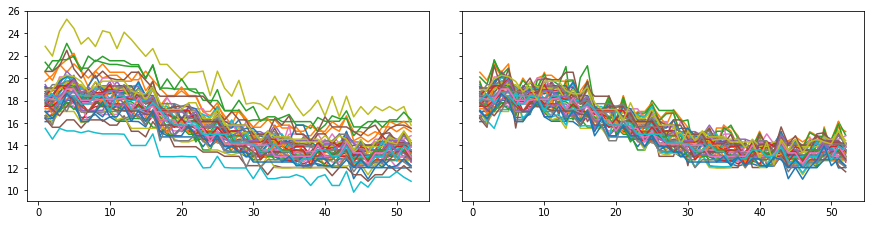

In [9]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 3.5), sharey=True )
plt.subplots_adjust(wspace=0.08)

for i in range(3800,3851):
    ax1.plot(np.arange(1,53),data_amp.loc[i,:])
    ax2.plot(np.arange(1,53),amp_hamp.loc[i,:])
    #ax3.plot(np.arange(1,53), amp_hamp_smooth.loc[i,:])


In [ ]:
for i in range(4037,4041):
    y = data_amp.loc[i,:]
    plt.plot(np.arange(1,53),y)

In [2]:
tensor_fra_list = []
tensor_test_fra_list = []
if False:
    for i in range(1,9):
        data_amp = pd.read_csv(f'..\Data\DataClean\\fra{i}_amp.csv')
        data_pha = pd.read_csv(f'..\Data\DataClean\\fra{i}_phase.csv')
        data_amp = data_amp.drop(index = range(20)).reset_index(drop=True) # drop first 20 rows
        data_pha = data_pha.drop(index = range(20)).reset_index(drop=True) 
        data_amp = my_utils.hampel_filtering(data_amp, window_size=51, smoothing_factor=0.8)
        data_amp.to_csv(f'..\Data\DataPreprocessed\\fra{i}_w51_hamp_sf08.csv', index=False)
        data_amp = my_utils.butterworth_filter(data_amp,1,10,100)
        data_amp = pd.DataFrame(scaler.fit_transform(data_amp), columns=data_amp.columns)
        data_pha = data_pha.apply(my_utils.phase_sanitization_inRange, axis=1)
        data_pha.to_csv(f'..\Data\DataPreprocessed\\fra{i}_calibratedPha.csv', index=False)
        #data_pha = pd.read_csv(f'..\Data\DataPreprocessed\\fra{i}_cleanPha.csv')
        dataset = pd.DataFrame(my_utils.make_alternating(data_amp, data_pha))
        tens = my_utils.create_tensor(dataset)
        tensor_fra_list.append(tens[25:])
        tensor_test_fra_list.append(tens[:25])
tensorFra = np.concatenate(tensor_fra_list,axis=0)
tensorTestFra = np.concatenate(tensor_test_fra_list, axis=0)

In [6]:
tensor_gio_list = []
tensor_test_gio_list = []
scaler = MinMaxScaler()
if True:
    for i in range(1,7):
        data_amp, data_pha = extract_amp_phase(f'..\RawData\gio{i}.csv', names=(f'gio{i}_amp.csv', f'gio{i}_phase.csv'))
        data_amp = data_amp.drop(index = range(20)).reset_index(drop=True) # drop first 20 rows
        data_pha = data_pha.drop(index = range(20)).reset_index(drop=True) 
        data_amp = my_utils.hampel_filtering(data_amp, window_size=51, smoothing_factor=0.8)
        data_amp.to_csv(f'..\Data\DataPreprocessed\gio{i}_w51_hamp_sf08.csv', index=False)
        data_amp = pd.DataFrame(scaler.fit_transform(data_amp), columns=data_amp.columns)
        data_pha = data_pha.apply(my_utils.phase_sanitization_inRange, axis=1)
        data_pha.to_csv(f'..\Data\DataPreprocessed\gio{i}_calibratedPha.csv', index=False)
        #data_pha = pd.read_csv(f'..\Data\DataPreprocessed\\fra{i}_cleanPha.csv')
        dataset = pd.DataFrame(my_utils.make_alternating(data_amp, data_pha))
        tens = my_utils.create_tensor(dataset)
        tensor_gio_list.append(tens[34:])
        tensor_test_gio_list.append(tens[:34])
tensorGio = np.concatenate(tensor_gio_list,axis=0)
tensorTestGio = np.concatenate(tensor_test_gio_list, axis=0)
print(tensorGio.shape)
print(tensorTestGio.shape)

(698, 200, 104)
(204, 200, 104)


In [8]:
tensor_laura_list = []
tensor_test_la_list = []
for i in range(1,8):
    data_amp, data_pha = pd.read_csv(f'..\Data\DataPreprocessed\laura{i}_w51_hamp_sf08.csv'), pd.read_csv(f'..\Data\DataPreprocessed\laura{i}_calibratedPha.csv')
    data_amp = pd.DataFrame(scaler.fit_transform(data_amp), columns=data_amp.columns)
    #data_pha = pd.read_csv(f'..\Data\DataPreprocessed\\laura{i}_cleanPha.csv')
    dataset = pd.DataFrame(my_utils.make_alternating(data_amp, data_pha))
    tens = my_utils.create_tensor(dataset)
    tensor_laura_list.append(tens[17:])
    tensor_test_la_list.append(tens[:17])
for i in range(1,6):
    data_amp, data_pha = pd.read_csv(f'..\Data\DataPreprocessed\lauraDay2_{i}_w51_hamp_sf08.csv'), pd.read_csv(f'..\Data\DataPreprocessed\lauraDay2_{i}_calibratedPha.csv')
    data_amp = pd.DataFrame(scaler.fit_transform(data_amp), columns=data_amp.columns)
    #data_pha = pd.read_csv(f'..\Data\DataPreprocessed\\laura{i}_cleanPha.csv')
    dataset = pd.DataFrame(my_utils.make_alternating(data_amp, data_pha))
    tens = my_utils.create_tensor(dataset)
    tensor_laura_list.append(tens[17:])
    tensor_test_la_list.append(tens[:17])

tensorLaura = np.concatenate(tensor_laura_list, axis=0)
tensorTestLaura = np.concatenate(tensor_test_la_list, axis=0)
print(tensorLaura.shape)
print(tensorTestLaura.shape)

(884, 200, 104)
(204, 200, 104)


In [9]:
tensor_fra_list = []
tensor_test_fra_list = []
for i in range(1,9):
    data_amp, data_pha = pd.read_csv(f'..\Data\DataPreprocessed\\fra{i}_w51_hamp_sf08.csv'), pd.read_csv(f'..\Data\DataPreprocessed\\fra{i}_calibratedPha.csv')
    data_amp = pd.DataFrame(scaler.fit_transform(data_amp), columns=data_amp.columns)
    dataset = pd.DataFrame(my_utils.make_alternating(data_amp, data_pha))
    tens = my_utils.create_tensor(dataset)
    tensor_fra_list.append(tens[25:])
    tensor_test_fra_list.append(tens[:25])

tensorFra = np.concatenate(tensor_fra_list, axis=0)
tensorTestFra = np.concatenate(tensor_test_fra_list, axis=0)
print(tensorFra.shape)
print(tensorTestFra.shape)

(739, 200, 104)
(200, 200, 104)


In [15]:
tensor_empty_list = []
tensor_test_emp_list = []
if True:
    for i in range(1,8):
        data_amp, data_pha = pd.read_csv(f'..\Data\DataClean\empty{i}_amp.csv'), pd.read_csv(f'..\Data\DataClean\empty{i}_phase.csv')
        data_amp = data_amp.drop(index = range(20)).reset_index(drop=True) # drop first 20 rows
        data_pha = data_pha.drop(index = range(20)).reset_index(drop=True) 
        data_amp = my_utils.hampel_filtering(data_amp, window_size=51, smoothing_factor=0.8)
        data_amp.to_csv(f'..\Data\DataPreprocessed\empty{i}_w51_hamp_sf08.csv', index=False)
        data_amp = pd.DataFrame(scaler.fit_transform(data_amp), columns=data_amp.columns)
        data_pha = data_pha.apply(my_utils.phase_sanitization_inRange, axis=1)
        data_pha.to_csv(f'..\Data\DataPreprocessed\empty{i}_calibratedPha.csv', index=False)
        dataset = pd.DataFrame(my_utils.make_alternating(data_amp, data_pha))
        tens = my_utils.create_tensor(dataset)
        tensor_empty_list.append(tens[16:])
        tensor_test_emp_list.append(tens[:16])
    for i in range(1,7):
        data_amp, data_pha = pd.read_csv(f'..\Data\DataClean\emptyDay2_{i}_amp.csv'), pd.read_csv(f'..\Data\DataClean\emptyDay2_{i}_phase.csv')
        data_amp = data_amp.drop(index = range(20)).reset_index(drop=True) # drop first 20 rows
        data_pha = data_pha.drop(index = range(20)).reset_index(drop=True) 
        data_amp = my_utils.hampel_filtering(data_amp, window_size=51, smoothing_factor=0.8)
        data_amp.to_csv(f'..\Data\DataPreprocessed\emptyDay2_{i}_w51_hamp_sf08.csv', index=False)
        data_amp = pd.DataFrame(scaler.fit_transform(data_amp), columns=data_amp.columns)
        data_pha = data_pha.apply(my_utils.phase_sanitization_inRange, axis=1)
        data_pha.to_csv(f'..\Data\DataPreprocessed\emptyDay2_{i}_calibratedPha.csv', index=False)
        dataset = pd.DataFrame(my_utils.make_alternating(data_amp, data_pha))
        tens = my_utils.create_tensor(dataset)
        tensor_empty_list.append(tens[16:])
        tensor_test_emp_list.append(tens[:16])
        
    tensorEmpty = np.concatenate(tensor_empty_list, axis=0)
    tensorTestEmpty = np.concatenate(tensor_test_emp_list, axis=0)
    print(tens)
    tensorEmpty.shape

[[[0.24670027 0.27927556 0.22832729 ... 0.21854195 0.49862516 0.27927556]
  [0.38914989 0.25303296 0.37665242 ... 0.16583542 0.37211608 0.25303296]
  [0.54148848 0.24422492 0.45527889 ... 0.20370959 0.77045292 0.24422492]
  ...
  [0.38914989 0.27417957 0.34852687 ... 0.19018481 0.4256711  0.27417957]
  [0.35436278 0.24816047 0.45527889 ... 0.20466837 0.44149694 0.24816047]
  [0.51978175 0.26916029 0.51267234 ... 0.21094665 0.61874309 0.26916029]]

 [[0.38914989 0.27826193 0.32415521 ... 0.19078025 0.4256711  0.27826193]
  [0.38914989 0.22657735 0.37665242 ... 0.16604386 0.44149694 0.22657735]
  [0.33873221 0.28472393 0.45527889 ... 0.19835339 0.46243189 0.28472393]
  ...
  [0.34264984 0.26180755 0.32823442 ... 0.19749148 0.46243189 0.26180755]
  [0.46466178 0.28134023 0.53527439 ... 0.22543548 0.4256711  0.28134023]
  [0.46466178 0.25564245 0.45527889 ... 0.19549128 0.62362306 0.25564245]]

 [[0.42342743 0.22855253 0.41234377 ... 0.23025745 0.50886547 0.22855253]
  [0.27914216 0.253045

In [16]:
tensor_gio_list = []
for i in range(1,7):
    data_amp, data_pha = pd.read_csv(f'..\Data\DataClean\gio{i}_amp.csv'), pd.read_csv(f'..\Data\DataClean\gio{i}_phase.csv')
    data_amp = data_amp.drop(index = range(20)).reset_index(drop=True) # drop first 20 rows
    data_pha = data_pha.drop(index = range(20)).reset_index(drop=True) 
    data_amp = my_utils.replace_outliers_mad(data_amp,thresh=3.5)
    dataset = pd.DataFrame(make_alternating(data_amp, data_pha))
    tensor_gio_list.append(my_utils.create_tensor(dataset))
tensorGio = np.concatenate(tensor_gio_list, axis=0)
tensorGio.shape

AttributeError: module 'my_utils' has no attribute 'replace_outliers_mad'

In [10]:
tensor_laura_list = []
tensor_test_la_list = []
if False:
    for i in range(1,8):
        data_amp = pd.read_csv(f'..\Data\DataClean\laura{i}_amp.csv')
        data_pha = pd.read_csv(f'..\Data\DataClean\laura{i}_phase.csv')
        data_amp = data_amp.drop(index = range(20)).reset_index(drop=True) # drop first 20 rows
        data_pha = data_pha.drop(index = range(20)).reset_index(drop=True) 
        data_amp = my_utils.hampel_filtering(data_amp, window_size=51, smoothing_factor=0.8)
        data_amp.to_csv(f'..\Data\DataPreprocessed\\laura{i}_w51_hamp_sf08.csv', index=False)
        data_amp = my_utils.butterworth_filter(data_amp,1,10,100)
        data_amp = pd.DataFrame(scaler.fit_transform(data_amp), columns=data_amp.columns)
        data_pha = data_pha.apply(my_utils.phase_sanitization_inRange, axis=1)
        data_pha.to_csv(f'..\Data\DataPreprocessed\\laura{i}_calibratedPha.csv', index=False)
        #data_pha = pd.read_csv(f'..\Data\DataPreprocessed\\laura{i}_cleanPha.csv')
        dataset = pd.DataFrame(my_utils.make_alternating(data_amp, data_pha))
        tens = my_utils.create_tensor(dataset)
        tensor_laura_list.append(tens[20:])
        tensor_test_la_list.append(tens[:20])
    for i in range(1,8):
        data_amp = pd.read_csv(f'..\Data\DataPreprocessed\laura{i}_w51_hamp_sf08.csv')
        data_pha = pd.read_csv(f'..\Data\DataPreprocessed\laura{i}_calibratedPha.csv')
        data_amp = my_utils.butterworth_filter(data_amp,1,10,100)
        data_amp = pd.DataFrame(scaler.fit_transform(data_amp), columns=data_amp.columns)
        dataset = pd.DataFrame(my_utils.make_alternating(data_amp, data_pha))
        tens = my_utils.create_tensor(dataset)
        tensor_laura_list.append(tens[20:])
        tensor_test_la_list.append(tens[:20])
    for i in range(1,6):
        data_amp = pd.read_csv(f'..\Data\DataClean\lauraDay2_{i}_amp.csv')
        data_pha = pd.read_csv(f'..\Data\DataClean\lauraDay2_{i}_phase.csv')
        data_amp = data_amp.drop(index = range(20)).reset_index(drop=True) # drop first 20 rows
        data_pha = data_pha.drop(index = range(20)).reset_index(drop=True) 
        data_amp = my_utils.hampel_filtering(data_amp, window_size=51, smoothing_factor=0.8)
        data_amp.to_csv(f'..\Data\DataPreprocessed\\lauraDay2_{i}_w51_hamp_sf08.csv', index=False)
        data_amp = my_utils.butterworth_filter(data_amp,1,10,100)
        data_amp = pd.DataFrame(scaler.fit_transform(data_amp), columns=data_amp.columns)
        data_pha = data_pha.apply(my_utils.phase_sanitization_inRange, axis=1)
        #data_pha = pd.read_csv(f'..\Data\DataPreprocessed\\lauraDay2_{i}_cleanPha.csv')
        data_pha.to_csv(f'..\Data\DataPreprocessed\\lauraDay2_{i}_calibratedPha.csv', index=False)
        dataset = pd.DataFrame(my_utils.make_alternating(data_amp, data_pha))
        tens = my_utils.create_tensor(dataset)
        tensor_laura_list.append(tens[20:])
        tensor_test_la_list.append(tens[:20])

tensorLaura= np.concatenate(tensor_laura_list, axis=0)
tensorTestLaura = np.concatenate(tensor_test_la_list, axis=0)
tensorLaura.shape

(848, 200, 104)

In [21]:
print(tensorTestLaura.shape)
print(tensorTestFra.shape)
print(tensorTestGio.shape)
print(tensorTestEmpty.shape)
print(tensorEmpty.shape)

(204, 200, 104)
(200, 200, 104)
(204, 200, 104)
(208, 200, 104)
(895, 200, 104)


In [ ]:
'''l_amp, l_pha = pd.read_csv('..\Data\DataClean\laura7_amp.csv'), pd.read_csv('..\Data\DataClean\laura7_phase.csv')
e_amp, e_pha =  pd.read_csv('..\Data\DataClean\empty7_amp.csv'), pd.read_csv('..\Data\DataClean\empty7_phase.csv')
l_amp = my_utils.replace_outliers_mad(l_amp, thresh=4)
e_amp = my_utils.replace_outliers_mad(e_amp, thresh=4)'''

In [9]:
'''test_amp, test_pha = pd.read_csv(f'..\Data\DataClean\emptyTest_amp.csv'), pd.read_csv(f'..\Data\DataClean\emptyTest_phase.csv')
test_ampL, test_phaL = pd.read_csv(f'..\Data\DataClean\lauraTest_amp.csv'), pd.read_csv(f'..\Data\DataClean\lauraTest_phase.csv')
test_amp = test_amp.drop(index = range(20)).reset_index(drop=True) 
test_pha = test_pha.drop(index = range(20)).reset_index(drop=True) 
test_amp = my_utils.replace_outliers_mad(test_amp, thresh=3.5)
test_amp = pd.DataFrame(scaler.fit_transform(test_amp), columns=test_amp.columns)
dataset1 = pd.DataFrame(make_alternating(test_amp, test_pha))
test_ampL = test_ampL.drop(index = range(20)).reset_index(drop=True) 
test_phaL = test_phaL.drop(index = range(20)).reset_index(drop=True) 
test_ampL = my_utils.replace_outliers_mad(test_ampL, thresh=3.5)
test_ampL = pd.DataFrame(scaler.fit_transform(test_ampL), columns=test_ampL.columns)
dataset2 = pd.DataFrame(make_alternating(test_ampL, test_phaL))'''


In [11]:
'''empty_test = my_utils.create_tensor(dataset1)
laura_test = my_utils.create_tensor(dataset2)
print(laura_test.shape)
empty_test.shape'''

(123, 200, 104)


(125, 200, 104)

In [22]:
#tensor1 = torch.from_numpy(tensorEmpty)
tensor2 = torch.from_numpy(tensorLaura)
tensor3 = torch.from_numpy(tensorFra)
tensor4 = torch.from_numpy(tensorGio)
tensor5 = torch.from_numpy(tensorEmpty)
# Assuming you have your data tensors tensor1 and tensor2 of shape (1135, 200, 104)
# Add a channel dimension to the input data
#tensor1 = tensor1.unsqueeze(1)  # Adds a channel dimension (1) at position 1
tensor2 = tensor2.unsqueeze(1)
tensor3 = tensor3.unsqueeze(1)
tensor4 = tensor4.unsqueeze(1)
tensor5 = tensor5.unsqueeze(1)
# Assuming you have 455 images of class 1 and 680 images of class 2
#labels1 = torch.zeros(1103, dtype=torch.long)  # Class 1 labels as 0
labels2 = torch.zeros(884, dtype=torch.long)   # Class 2 labels as 1
labels3 = torch.ones(739, dtype=torch.long) # Class 3 labels as 2
labels4 = torch.ones(698, dtype=torch.long) + 1
labels5 = torch.ones(895, dtype=torch.long) + 2
# Combine Data and Labels
data = torch.cat((tensor2, tensor3, tensor4, tensor5), dim=0)
labels = torch.cat((labels2, labels3, labels4, labels5), dim=0)

#dataset = TensorDataset(data, labels) #dataset = TensorDataset(data, labels)
### dataset = torch.load('..\Data\DatasetTensor\empty_laura.pt')
train_dataset = TensorDataset(data,labels)

tt2 = torch.from_numpy(tensorTestLaura)
tt3 = torch.from_numpy(tensorTestFra)
tt4 = torch.from_numpy(tensorTestGio)
tt5 = torch.from_numpy(tensorTestEmpty)
tt2 = tt2.unsqueeze(1)
tt3 = tt3.unsqueeze(1)
tt4 = tt4.unsqueeze(1)
tt5 = tt5.unsqueeze(1)
ll2 = torch.zeros(204, dtype=torch.long)
ll3 = torch.ones(200, dtype=torch.long)
ll4 = torch.ones(204, dtype=torch.long) + 1 #label = 2
ll5 = torch.ones(208, dtype=torch.long) + 2
dataT = torch.cat((tt2, tt3, tt4, tt5), dim=0)
labelsT = torch.cat((ll2, ll3, ll4, ll5), dim=0)
test_dataset = TensorDataset(dataT,labelsT)
'''
tt1 = torch.from_numpy(empty_test).unsqueeze(1)
tt2 = torch.from_numpy(laura_test).unsqueeze(1)
ll1 = torch.zeros(123, dtype=torch.long)
ll2 = torch.ones(125, dtype=torch.long)
dd = torch.cat((tt1, tt2), dim=0)
ll = torch.cat((ll1, ll2), dim=0)
test_dataset = TensorDataset(dd,ll)
'''
# Define the sizes for your train and test sets
#train_size = int(0.8 * len(dataset))  # 80% for training
#test_size = len(dataset) - train_size  # 20% for testing
# Split the dataset into train and test
#train_dataset, test_dataset = random_split(dataset, [train_size, test_size])
# Create DataLoaders
batch_size = 64  # Adjust as needed
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size)
train_dataset.tensors[0].shape

torch.Size([3216, 1, 200, 104])

In [23]:
torch.save(train_dataset,'train_emptylafragio.pt')
torch.save(test_dataset,'test_emptylafragio.pt')

In [13]:
# Assuming you have created your TensorDataset as dataset
dataset = torch.load('..\Data\DatasetTensor\empty_laura_fra.pt')

# Define the indices for the train and test sets
train_indices = list(range(210, 1500)) + list(range(1710, 2920))
test_indices = list(range(210)) + list(range(1500, 1710)) + list(range(2920, 3130))

# Create TensorDataset for train and test sets
train_dataset = TensorDataset(dataset.tensors[0][train_indices], dataset.tensors[1][train_indices])
test_dataset = TensorDataset(dataset.tensors[0][test_indices], dataset.tensors[1][test_indices])

# Create DataLoader objects for training and testing
batch_size = 64  # Adjust the batch size as needed
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)


In [21]:
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 64, 4, stride=(1,2))
        self.pool = nn.MaxPool2d(2, 2, padding=1)
        self.poolLast = nn.MaxPool2d(2,2, padding=1)
        self.conv2 = nn.Conv2d(64, 32, 6)
        self.conv3 = nn.Conv2d(32, 32, 6)
        self.fc1 = nn.Linear(2816, 32)
        self.fc2 = nn.Linear(32, 2)
        self.dropoutConv = nn.Dropout2d(p=0.3)

    def forward(self, x):
        x = x.to(self.conv1.bias.dtype)
        x = self.pool(F.relu(self.conv1(x))) # 200x104 -> 197x51 -> 199x53 -> 99x26
        x = self.conv2(x)
        x = self.dropoutConv(x)
        x = self.pool(F.relu(x)) # 99x26 -> 95x22 -> 97x24 -> 48 x 12
        x = self.conv3(x)
        x = self.dropoutConv(x)
        x = self.poolLast(F.relu(x)) # 48x12 -> 44x8 -> 22x4
        x = torch.flatten(x, 1) # flatten all dimensions except batch -> 88*Channels
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x
    
net = Net()
class_weights = [848/1587, 739/1587, ]
class_weights = torch.FloatTensor(class_weights)
criterion = nn.CrossEntropyLoss(weight=class_weights)


In [19]:
loss_every_10_batches = []
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)
net.train()
for epoch in range(100):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(train_loader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 10 == 9:  # Print every 2 minibatches (0-based indexing)
            print(f'[{epoch + 1}, {i + 1}] loss: {running_loss / 10}')
            loss_every_10_batches.append(running_loss / 10)
            running_loss = 0.0

print('Finished Training')
ll = np.array(loss_every_10_batches)

[1, 10] loss: 0.6906749844551087
[1, 20] loss: 0.6817522048950195
[2, 10] loss: 0.6845735967159271
[2, 20] loss: 0.6831693530082703
[3, 10] loss: 0.6790499210357666
[3, 20] loss: 0.6840233922004699
[4, 10] loss: 0.687446242570877
[4, 20] loss: 0.6852140903472901
[5, 10] loss: 0.6776577293872833
[5, 20] loss: 0.6932017624378204


KeyboardInterrupt: 

(200,)

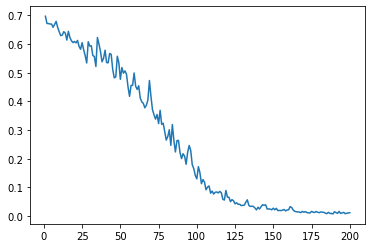

In [72]:
ll = np.array(loss_every_10_batches)
plt.plot(np.arange(1,ll.shape[0]+1), ll)
ll.shape

In [35]:
torch.save(dataset, 'laura_fra.pt')

In [73]:
from sklearn.metrics import confusion_matrix
correct = 0
total = 0
# since we're not training, we don't need to calculate the gradients for our outputs
net.eval()
with torch.no_grad():
    for data in test_loader:
        images, labels = data
        # calculate outputs by running images through the network
        outputs = net(images)
        # the class with the highest energy is what we choose as prediction
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Accuracy of the network on the {total} test images: {100 * correct // total} %')
total

Accuracy of the network on the 440 test images: 71 %


440

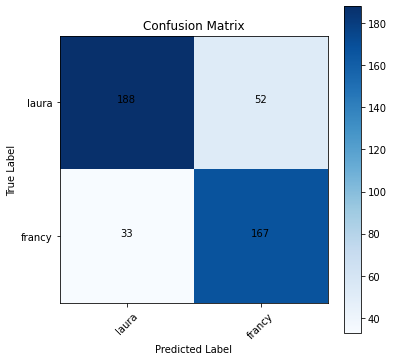

In [43]:
# Initialize variables to store true labels and predicted labels
true_labels = []
predicted_labels = []

# Set the network to evaluation mode
net.eval()

# Disable gradient computation for inference
with torch.no_grad():
    for data in test_loader:
        images, labels = data
        outputs = net(images)
        _, predicted = torch.max(outputs, 1)

        true_labels.extend(labels.numpy())  # Convert labels to a NumPy array and extend the list
        predicted_labels.extend(predicted.numpy())  # Convert predicted labels to a NumPy array and extend the list

# Convert the lists to NumPy arrays
true_labels = np.array(true_labels)
predicted_labels = np.array(predicted_labels)

# Create the confusion matrix
conf_matrix = confusion_matrix(true_labels, predicted_labels)

# Plot the confusion matrix as a heatmap
plt.figure(figsize=(6, 6))
plt.imshow(conf_matrix, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()
classes=['laura', 'francy']
tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes, rotation=45)
plt.yticks(tick_marks, classes)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
for i in range(len(classes)):
    for j in range(len(classes)):
        plt.text(j, i, str(conf_matrix[i, j]), horizontalalignment="center", color="black")
# Display the confusion matrix
plt.show()

In [42]:
torch.save(dataset, '..\Data\DatasetTensor\empty_laura_fra.pt')